In [1]:
# some standard packages
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from random import shuffle

# modelling packages
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import model_from_json
# from tensorflow.keras.models import load_model

# Importing tf tools
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix


Utilize the cell below only if using all of the Data Loader file instead of using the Keras Image Generator.

In [2]:
# Open the data files
# X = pickle.load(open('X.pickle', 'rb'))
# y = pickle.load(open('y.pickle', 'rb'))

In [3]:
os.getcwd()

'/home/ec2-user/SageMaker/InvasiveID-Model'

In [4]:
categories = ['class_0', 'class_1', 'class_2']

# , 'class_3'

In [29]:
# Creating a nested for-loop that will move 20% of the images for each class into a test set
for each_category in categories: 
    
    # Make the directory
    #os.mkdir(path + f'test/{each_category}')
    
    # Getting a list of the images
    list_images = [file for file in os.listdir(f'/home/ec2-user/SageMaker/data/temp_big_BC/{each_category}') if file.endswith('.jpg')]
    
    # Randomly shuffling the order 
    shuffle(list_images)
    
    # Getting the names of the first 20% of images
    num_test_images = int(len(list_images)*0.2)
    for_testset = list_images[ : num_test_images]
    
    # Looping through each image in this list 'for_testset'
    for each_image in for_testset:
        
        # Renaming the file path to move those image to test set
        os.rename(f'/home/ec2-user/SageMaker/data/temp_big_BC/{each_category}/{each_image}', 
                  f'/home/ec2-user/SageMaker/data/temp_big_BC/test/{each_category}/{each_image}')
        
        # Sanity check
        print(f'{each_image} moved to "{each_category}" in test.')
    
    # Another check
    print(f'{each_category} completed.')

6614786065_a0f8c90c96_s.jpg moved to "class_0" in test.
6169071915_ecbb993e18_s.jpg moved to "class_0" in test.
6169607486_3acfe068cb_q.jpg moved to "class_0" in test.
19136852960_56f3a8732b_s.jpg moved to "class_0" in test.
26363890440_6f4ac9d273_s.jpg moved to "class_0" in test.
3622816738_45f54862c7_s.jpg moved to "class_0" in test.
7446338758_d8612c8d31_q.jpg moved to "class_0" in test.
33745602418_3d44a899b0_s.jpg moved to "class_0" in test.
9284452807_b2bae274a2_s.jpg moved to "class_0" in test.
48491354072_78a0de2f92_s.jpg moved to "class_0" in test.
13292937975_57ed9e4132_s.jpg moved to "class_0" in test.
4745254081_6770f5746e_q.jpg moved to "class_0" in test.
50017116431_0c226ef214_s.jpg moved to "class_0" in test.
49618211156_03d1dbbb62_q.jpg moved to "class_0" in test.
21350046484_dacc5bd33b_s.jpg moved to "class_0" in test.
27361906131_7f2f0a2dba_s.jpg moved to "class_0" in test.
395096561_15c95a8788_q.jpg moved to "class_0" in test.
48360353552_e6b2294625_s.jpg moved to "c

In [30]:
# Use the Keras ImageDataGenerator for memory efficiency and preprocessing ease
# This process replaces the method of obtaining our data via DataLoader.ipynb
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
#     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

In [31]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
# train_img_dir = 'Data/train/'
# test_img_dir = 'Data/test/'

In [32]:
batch_size = 32

In [10]:
# # Open the data files
# train = pickle.load(open('train_labels.pickle', 'rb'))
# test = pickle.load(open('test_labels.pickle', 'rb'))

In [11]:
# train.head()

In [12]:
# train['Label'].value_counts()

In [13]:
# train.shape

In [33]:
train_generator = train_datagen.flow_from_directory(
                                                    '/home/ec2-user/SageMaker/data/temp_big_BC/train',
                                                    target_size=(32, 32),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

Found 8073 images belonging to 3 classes.


In [34]:
validation_generator = train_datagen.flow_from_directory(
                                                        '/home/ec2-user/SageMaker/data/temp_big_BC/train/',
                                                        target_size=(32, 32),
                                                        color_mode='rgb',
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        subset='validation'
                                                        )

Found 2018 images belonging to 3 classes.


In [35]:
test_generator = test_datagen.flow_from_directory(
                                                  '/home/ec2-user/SageMaker/data/temp_big_BC/test/',
                                                  target_size=(32, 32),
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2522 images belonging to 3 classes.


In [36]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size 

valid_stepsize = validation_generator.samples//validation_generator.batch_size 

test_stepsize = test_generator.samples//test_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize} \nTest step size = {test_stepsize}')

Training step size = 252 
Validation step size = 63 
Test step size = 78


## VGG-16

In [37]:
# 1.  Import the pretrained VGG16 network, do not include the top layers
pretrained_VGG = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(32, 32, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_VGG.layers:
    layer.trainable=False
    
# Display VGG16 architecture
pretrained_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [38]:

# Instantiate the VGG16 NN model 
weeds_VGG = Sequential()

# Add the pretrained layers 
weeds_VGG.add(pretrained_VGG)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
weeds_VGG.add(Dense(256, activation='relu'))
weeds_VGG.add(Dropout(0.5))
weeds_VGG.add(Dense(512, activation='relu'))

# Adding our activation 
weeds_VGG.add(Dense(3, activation='softmax'))

In [39]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [40]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
weeds_VGG.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
weeds_VGG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1539      
Total params: 14,979,139
Trainable params: 264,451
Non-trainable params: 14,714,688
_________________________________________________________________


### VGG16 Training

In [41]:
# Fitting the model to the training data
history_VGG = weeds_VGG.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 252 steps, validate for 63 steps
Epoch 1/50
 36/252 [===>..........................] - ETA: 27s - loss: 1.1206 - acc: 0.3525WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc


UnknownError:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f1c6d90ee60>
Traceback (most recent call last):

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/script_ops.py", line 236, in __call__
    ret = func(*args)

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_preprocessing/image/utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/PIL/Image.py", line 2862, in open
    "cannot identify image file %r" % (filename if filename else fp)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f1c6d90ee60>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_distributed_function_10460]

Function call stack:
distributed_function


SyntaxError: invalid syntax (<ipython-input-42-9d0915aaa9f8>, line 1)

### VGG16 Results

In [23]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_VGG = weeds_VGG.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_VGG = test_probas_VGG.argmax(axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [24]:
# Getting the true class labels for the test set
test_true_VGG = test_generator.classes

# Sanity check 
len(test_true_VGG)

800

In [25]:
# Look at what our model predicted
test_predictions_VGG

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

In [26]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_VGG, test_predictions_VGG, target_names=categories))

Classification Report
 
               precision    recall  f1-score   support

     class_0       0.74      0.79      0.76       300
     class_1       0.76      0.84      0.80       258
     class_2       0.88      0.69      0.77       242

    accuracy                           0.78       800
   macro avg       0.79      0.78      0.78       800
weighted avg       0.79      0.78      0.78       800



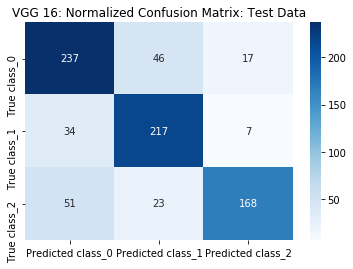

In [27]:
# Get a confusion matrix 
test_matrix_VGG = pd.DataFrame(confusion_matrix(test_true_VGG, test_predictions_VGG), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_VGG, cmap='Blues', annot=True, fmt='g')
plt.title('VGG 16: Normalized Confusion Matrix: Test Data')
plt.show()

## Resnet50  Model

In [ ]:
# 1.  Import the pretrained ResNet network, do not include the top layers
pretrained_ResNet = ResNet50(weights='imagenet', include_top=False, pooling='max', classes=4, input_shape=(32, 32, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_ResNet.layers:
    layer.trainable=False
    
# Display ResNet architecture
pretrained_ResNet.summary()

In [ ]:
# Instantiate the ResNet50 NN model 
weeds_ResNet = Sequential()

# Add the pretrained layers 
weeds_ResNet.add(pretrained_ResNet)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
weeds_ResNet.add(Dense(256, activation='relu'))
weeds_ResNet.add(Dropout(0.5))
weeds_ResNet.add(Dense(512, activation='relu'))

# Adding our activation 
weeds_ResNet.add(Dense(4, activation='softmax'))

In [ ]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [ ]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
weeds_ResNet.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
weeds_ResNet.summary()

### ResNet50 Training

In [ ]:
# Fitting the model to the training data
history_ResNet = weeds_ResNet.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])

### ResNet50 Results

In [ ]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_ResNet = weeds_ResNet.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_ResNet = test_probas_ResNet.argmax(axis=1)

In [ ]:
# Getting the true class labels for the test set
test_true_ResNet = test_generator.classes

# Sanity check 
test_true_ResNet

In [ ]:
# Look at what our model predicted
test_predictions_ResNet

In [ ]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_ResNet, test_predictions_ResNet, target_names=categories))

In [ ]:
# Get a confusion matrix 
test_matrix_ResNet = pd.DataFrame(confusion_matrix(test_true_ResNet, test_predictions_ResNet), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_ResNet, cmap='Blues', annot=True, fmt='g')
plt.title('ResNet50 Normalized Confusion Matrix: Test Data')
plt.show()

## Xception Model
Load pretrained base model and add 3 layers + o/p layer to Xception_model.

In [ ]:
# Import the pretrained Xception network, do not include the top layers
pretrained_Xception = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Model Architecture
x = pretrained_Xception.output # adding layers after Xception o/p
# x = MaxPooling2D((2,2))(x) # pooling layer to reduce comp time
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # turn off 50% of nodes to reduce overfitting
preds = Dense(3, activation='softmax')(x)

# Display Xception architecture
pretrained_Xception.summary()
Xception_model = Model(inputs=pretrained_Xception.input, outputs=preds)
Xception_model.summary()

In [ ]:
#  Freezing Xception Base, (we're only training the last 3 layers).
for layer in Xception_model.layers[:-3]:
    layer.trainable=False
    
for layer in Xception_model.layers[-3:]:
    layer.trainable=True
    print(layer)
    

In [ ]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='min', min_delta=0.0001, verbose=1)

In [ ]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = 'Adam'

# Compiling the CNN model 
Xception_model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary 
Xception_model.summary()

### Xception Training

In [ ]:
# Fitting the model to the training data
history_Xception = Xception_model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES]
                                )
# 

### Xception Results

In [ ]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_Xception = Xception_model.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_Xception = test_probas_Xception.argmax(axis=1)

In [ ]:
# Getting the true class labels for the test set
test_true_Xception = test_generator.classes

# Sanity check 
test_true_Xception

In [ ]:
# Look at what our model predicted
test_predictions_Xception

In [ ]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_Xception, test_predictions_Xception, target_names=categories))

In [ ]:
# Get a confusion matrix 
test_matrix_Xception = pd.DataFrame(confusion_matrix(test_true_Xception, test_predictions_Xception), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_Xception, cmap='Blues', annot=True, fmt='g')
plt.title('Normalized Confusion Matrix: Test Data')
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y) 

In [ ]:
# Building the Model
model = Sequential()

# # 3 convolutional layers
model.add(Conv2D(28, (3,3), input_shape = (28,28,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

# The output layer with 9 neurons for 9 classes
model.add(Dense(9))
model.add(Activation('softmax'))

# Compiling the model using some basic parameters
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
train_generator.filenames

In [ ]:
# Train the model
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_stepsize,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=valid_stepsize)

# callbacks=[
#                         EarlyStopping(patience=3, restore_best_weights=True),
#                         ReduceLROnPlateau(patience=2)],